In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

from datetime import date

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score
from scipy import interp

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'nltk'

In [70]:
import os
os.getcwd()

'/Users/Jak/Project_code/DSRCompTwo/3.Model'

In [71]:
path = "/Users/Jak/Project_code/DSRCompTwo/4.Data/Y_all_v3.pkl"

In [72]:
with open(path, "rb") as data: 
    y_labels = pickle.load(data)

In [73]:
y_labels

,Label
Date,
2008-08-08,0
2008-08-11,1
2008-08-12,0
2008-08-13,0
2008-08-14,1
...,...
2014-11-14,0
2014-11-17,1
2014-11-18,1


In [74]:
#List to keep different methods scores to compare
ScoreSummaryByMethod=[]

In [75]:
df=pd.read_csv('../0.Raw_data/train/Combined_News_DJIA_train.csv')
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)

y_labels = y_labels.reset_index()

df['Label'] = y_labels['Label']

In [76]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2013,11,15)),['Label','Combined']]
train.head()

#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2013,11,15)),['Label','Combined']]
test.head()

,Label,Combined
1329,1,[nan 'BBC News - Huge bomb hits Syria governme...
1330,0,['Amsterdam pays alcoholics in beer to clean s...
1331,0,['LG Smart TVs logging USB filenames and viewi...
1332,1,"[""Wikipedia names Texas PR firm over false man..."
1333,1,['Richard Branson says Virgin Galactic will ac...


In [77]:
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    2. Removes  stopwords
    3. Stems
    4. Returns a list of the cleaned text
    """
    if pd.isna(text):
        return []
    
    if pd.isnull(text):
        return []
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed
    

In [78]:
def ROCCurves (Actual, Predicted):
    '''
    Plot ROC curves for the multiclass problem
    based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Actual.values, Predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Actual.ravel(), Predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

In [79]:
def heatmap(data, rotate_xticks=True):
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(data, cmap=plt.cm.Blues)
    ax.xaxis.tick_top()
    if rotate_xticks:
        plt.xticks(rotation=90)
    plt.yticks(rotation=0)

In [80]:
def plot_classification_report(classification_report):     
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)
    aveTotal = lines[len(lines) - 1].split()
    classes.append('avg/total')
    vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
    plotMat.append(vAveTotal)
    df_classification_report = DataFrame(plotMat, index=classes,columns=['precision', 'recall', 'f1-score'])
    heatmap(df_classification_report)

def plot_confusion_matrix(confusion_matrix,classes=['0','1']):
    df_confusion_matrix = DataFrame(confusion_matrix, index=classes,columns=classes)
    heatmap(df_confusion_matrix,False)

In [81]:
def Evaluation (Method,Comment,Actual, Predicted):
    '''
        Prints and plots
        - classification report
        - confusion matrix
        - ROC-AUC
    '''
    print (Method)
    print (Comment)
    print (classification_report(Actual,Predicted))
    #plot_classification_report(classification_report(Actual,Predicted))
    print ('Confussion matrix:\n', confusion_matrix(Actual,Predicted))
    #plot_confusion_matrix(confusion_matrix(Actual,Predicted))
    ROC_AUC=roc_auc_score(Actual,Predicted)
    print ('ROC-AUC: ' + str(ROC_AUC))
    #ROCCurves (Actual,Predicted)
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)
    ScoreSummaryByMethod.append([Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1])

In [82]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
nb_pipeline.fit(train['Combined'],train['Label'])
predictions = nb_pipeline.predict(test['Combined'])
Evaluation ('MultinomialNB','no shift, no n-grams, combined Top news',test["Label"], predictions)


MultinomialNB
no shift, no n-grams, combined Top news
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       112
          1       0.56      1.00      0.72       143

avg / total       0.31      0.56      0.40       255

Confussion matrix:
 [[  0 112]
 [  0 143]]
ROC-AUC: 0.5


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
#Creating a Data Pipeline for Bernoulli Naive Bayes classifier classifier and n-grams, default alpha=1
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', BernoulliNB(binarize=0.0)),  # train on TF-IDF vectors w/ Bernoulli Naive Bayes classifier
])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
Evaluation ('BernoulliNB(binarize=0.0)','default alpha=1,no shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(binarize=0.0)
default alpha=1,no shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

          0       0.42      0.30      0.35       112
          1       0.55      0.67      0.61       143

avg / total       0.49      0.51      0.49       255

Confussion matrix:
 [[34 78]
 [47 96]]
ROC-AUC: 0.4874500499500499


In [84]:
#1 days shift
df.Label = df.Label.shift(-1)

In [85]:
df.drop(df.index[len(df)-1], inplace=True)

In [86]:
#new train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2013,8,15)),['Label','Combined']]
#new test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2013,8,15)),['Label','Combined']]

In [87]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 1-day shift is smoothing alpha = 0 
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.0, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
Evaluation ('BernoulliNB(alpha=0.0,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

//anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


BernoulliNB(alpha=0.0,binarize=0.0)
1-day shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.47      0.34      0.39       141
        1.0       0.57      0.69      0.62       178

avg / total       0.52      0.54      0.52       319

Confussion matrix:
 [[ 48  93]
 [ 55 123]]
ROC-AUC: 0.5157183839349749


In [88]:
#3 days shift
df.Label = df.Label.shift(-2)
df.drop(df.index[len(df)-1], inplace=True)
df.drop(df.index[len(df)-1], inplace=True)

In [89]:
#new train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2013,8,15)),['Label','Combined']]
#new test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2013,8,15)),['Label','Combined']]

In [90]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 3-day shift is smoothing alpha = 0.5 
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.51      0.47      0.49       139
        1.0       0.61      0.65      0.63       178

avg / total       0.56      0.57      0.57       317

Confussion matrix:
 [[ 65  74]
 [ 63 115]]
ROC-AUC: 0.5568466575054563


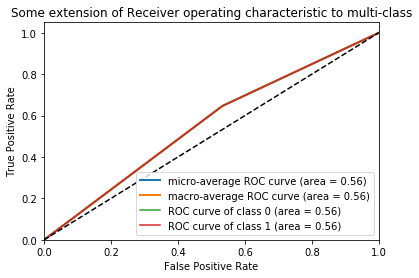

In [91]:
ROCCurves (test["Label"], predictions)

### Altering combinations of top news columns

In [92]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 3-day shift is smoothing alpha = 0.5 
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])


In [93]:
df=pd.read_csv('../0.Raw_data/raw/Combined_News_DJIA.csv')


In [94]:
#Combination 10 and 25
df['Combined10_25']=df.iloc[:,[11,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
#Combination 12 and 25
df['Combined12_25']=df.iloc[:,[13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [95]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2013,8,15)),['Label','Top1','Top12','Top25','Combined10_25','Combined12_25','Combined3_12_25']]
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2013,8,15)),['Label','Top1','Top12','Top25','Combined10_25','Combined12_25','Combined3_12_25']]

In [96]:
#no changes in the pipeline. We just use other data sets
#Top1, no shift, baseline
bnb_2ngram_pipeline.fit(train['Top1'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Top1'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Top1 only',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Top1 only
             precision    recall  f1-score   support

          0       0.51      0.44      0.47       341
          1       0.56      0.63      0.59       384

avg / total       0.54      0.54      0.54       725

Confussion matrix:
 [[149 192]
 [141 243]]
ROC-AUC: 0.534881323313783


In [97]:
#no changes in the pipeline. We just use other data sets
#Top25, no shift
bnb_2ngram_pipeline.fit(train['Top25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Top25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Top25 only',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Top25 only
             precision    recall  f1-score   support

          0       0.50      0.43      0.46       341
          1       0.55      0.62      0.58       384

avg / total       0.53      0.53      0.53       725

Confussion matrix:
 [[145 196]
 [145 239]]
ROC-AUC: 0.5238078873411535


In [98]:
#no changes in the pipeline. We just use other data sets
#Combined12_25, no shift
bnb_2ngram_pipeline.fit(train['Combined12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined12_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Combined Top12 and Top25',test["Label"], predictions)


BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Combined Top12 and Top25
             precision    recall  f1-score   support

          0       0.51      0.49      0.50       341
          1       0.56      0.59      0.58       384

avg / total       0.54      0.54      0.54       725

Confussion matrix:
 [[166 175]
 [157 227]]
ROC-AUC: 0.5389746761974585


In [99]:
#no changes in the pipeline. We just use other data sets
#Combined10_25, no shift
bnb_2ngram_pipeline.fit(train['Combined10_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined10_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Combined Top10 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Combined Top10 and Top25
             precision    recall  f1-score   support

          0       0.54      0.42      0.47       341
          1       0.57      0.68      0.62       384

avg / total       0.55      0.56      0.55       725

Confussion matrix:
 [[142 199]
 [122 262]]
ROC-AUC: 0.549356977028348


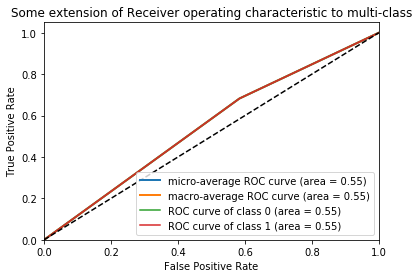

In [100]:
ROCCurves (test["Label"], predictions)

In [101]:
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)

In [102]:
#Combination 3,12 and 25
df['Combined3_12_25']=df.iloc[:,[4,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [103]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2013,8,15)),['Label','Combined3_12_25']]
train.head()

,Label,Combined3_12_25
0,0.0,"[""b'Russia Today: Columns of troops roll into ..."
1,0.0,"['b""Jewish Georgian minister: Thanks to Israel..."
2,1.0,"['b\'""If we had no sexual harassment we would ..."
3,1.0,"[""b' Israel clears troops who killed Reuters c..."
4,0.0,"[""b'Swedish wrestler Ara Abrahamian throws awa..."


In [104]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2013,8,15)),['Label','Combined3_12_25']]
test.tail()

,Label,Combined3_12_25
1982,0.0,['Report: China is still harvesting organs fro...
1983,1.0,['Nicola Sturgeon says a second independence r...
1984,1.0,"[""Poland 'shocked' by xenophobic abuse of Pole..."
1985,1.0,"[""S&amp;P cuts United Kingdom sovereign credit..."
1986,1.0,['UK must accept freedom of movement to access...


In [105]:
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Combined10_25,Combined12_25,Combined3_12_25
0,2008-08-08,0.0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","[""b'Did the U.S. Prep Georgia for War with Rus...","[""b'Announcing:Class Action Lawsuit on Behalf ...","[""b'Russia Today: Columns of troops roll into ..."
1,2008-08-11,0.0,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...","['b""Georgia\'s move, a mistake of monumental p...","[""b'Abhinav Bindra wins first ever Individual ...","['b""Jewish Georgian minister: Thanks to Israel..."
2,2008-08-12,1.0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,"b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...","[""b'U.S. Beats War Drum as Iran Dumps the Doll...","[""b'CNN use footage of Tskhinvali ruins to cov...","['b\'""If we had no sexual harassment we would ..."
3,2008-08-13,1.0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,"b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,"['b""92% of CNN readers: Russia\'s actions in G...","['b""US warns against Israeli plan to strike ag...","[""b' Israel clears troops who killed Reuters c..."
4,2008-08-14,0.0,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That K

In [106]:
df['Combined3_12_25'][3]

'["b\' Israel clears troops who killed Reuters cameraman\'"\n \'b"US warns against Israeli plan to strike against Iran\\\'s nuclear facilities"\'\n "b\'2006: Nobel laureate Aleksander Solzhenitsyn accuses U.S., NATO of encircling Russia\'"]'

In [107]:
#no changes in the pipeline. We just use other data sets
#Combined Top3, Top12 and Top25, 3-days shift
bnb_2ngram_pipeline.fit(train['Combined3_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.48      0.45      0.46       339
        1.0       0.54      0.57      0.55       384

avg / total       0.51      0.51      0.51       723

Confussion matrix:
 [[153 186]
 [167 217]]
ROC-AUC: 0.5082158001474926


In [108]:
#let's shift the data and explore Top1 and Top6 combination for 3 days shift
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)

In [109]:
#Combination 1 and 6
df['Combined1_6']=df.iloc[:,[2,7]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [110]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2013,8,15)),['Label','Combined1_6']]
train.head()

,Label,Combined1_6
0,0.0,"['b""Georgia \'downs two Russian warplanes\' as..."
1,1.0,"[""b'Why wont America and Nato help us? If they..."
2,1.0,"[""b'Remember that adorable 9-year-old who sang..."
3,0.0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,0.0,"[""b'All the experts admit that we should legal..."


In [111]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2013,8,15)),['Label','Combined1_6']]
test.tail()

,Label,Combined1_6
1981,0.0,['German government agrees to ban fracking ind...
1982,1.0,['Today The United Kingdom decides whether to ...
1983,1.0,['David Cameron to Resign as PM After EU Refer...
1984,1.0,['Barclays and RBS shares suspended from tradi...
1985,1.0,"['2,500 Scientists To Australia: If You Want T..."


In [112]:
#no changes in the pipeline. We just use other data sets
#Combined Top1 and Top6, 3-days shift
bnb_2ngram_pipeline.fit(train['Combined1_6'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined1_6'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2),Combined Top1 and Top6',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2),Combined Top1 and Top6
             precision    recall  f1-score   support

        0.0       0.48      0.46      0.47       338
        1.0       0.54      0.55      0.55       384

avg / total       0.51      0.51      0.51       722

Confussion matrix:
 [[157 181]
 [172 212]]
ROC-AUC: 0.5082901873767259


In [113]:
#Combination 3, 10, 15, 20, 25
df['Combined3_10_15_20_25']=df.iloc[:,[4,11, 16, 21, 26]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [114]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2013,8,15)),['Label','Combined3_10_15_20_25']]
train.head()

,Label,Combined3_10_15_20_25
0,0.0,"[""b'Russia Today: Columns of troops roll into ..."
1,1.0,"['b""Jewish Georgian minister: Thanks to Israel..."
2,1.0,"['b\'""If we had no sexual harassment we would ..."
3,0.0,"[""b' Israel clears troops who killed Reuters c..."
4,0.0,"[""b'Swedish wrestler Ara Abrahamian throws awa..."


In [115]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2013,8,15)),['Label','Combined3_10_15_20_25']]
test.tail()

,Label,Combined3_10_15_20_25
1981,0.0,['Pakistan is selling nuclear materials to N K...
1982,1.0,['Report: China is still harvesting organs fro...
1983,1.0,['Nicola Sturgeon says a second independence r...
1984,1.0,"[""Poland 'shocked' by xenophobic abuse of Pole..."
1985,1.0,"[""S&amp;P cuts United Kingdom sovereign credit..."


In [116]:
#no changes in the pipeline. We just use other data sets
#Combined top3, 10... etc
bnb_2ngram_pipeline.fit(train['Combined3_10_15_20_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_10_15_20_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2),Combined top3, 10, 15, 20, 25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2),Combined top3, 10, 15, 20, 25
             precision    recall  f1-score   support

        0.0       0.48      0.47      0.47       338
        1.0       0.54      0.55      0.54       384

avg / total       0.51      0.51      0.51       722

Confussion matrix:
 [[159 179]
 [174 210]]
ROC-AUC: 0.508644600591716


In [117]:
df_ScoreSummaryByMethod=DataFrame(ScoreSummaryByMethod,columns=['Method','Comment','ROC_AUC','Precision','Accuracy','Recall','F1'])
df_ScoreSummaryByMethod.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_ScoreSummaryByMethod.head(20)

,Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.556847,0.608466,0.567823,0.646067,0.626703
7,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Combined Top10 an...",0.549357,0.568330,0.557241,0.682292,0.620118
6,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Combined Top12 an...",0.538975,0.564677,0.542069,0.591146,0.577608
4,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Top1 only",0.534881,0.558621,0.540690,0.632812,0.593407
5,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Top25 only",0.523808,0.549425,0.529655,0.622396,0.583639
2,"BernoulliNB(alpha=0.0,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.515718,0.569444,0.536050,0.691011,0.624365
10,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2),Combined top3...",0.508645,0.539846,0.511080,0.546875,0.543338
9,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2),Combined Top1...",0.508290,0.539440,0.511080,0.552083,0.545689
8,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.508216,0.538462,0.511757,0.565104,0.551461
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.500000,0.560784,0.560784,1.000000,0.718593


In [118]:
print(df_ScoreSummaryByMethod['Comment'])

3     3-days shift, ngram_range=(1, 2), combined Top...
7     no shift, ngram_range=(1, 2),Combined Top10 an...
6     no shift, ngram_range=(1, 2),Combined Top12 an...
4                no shift, ngram_range=(1, 2),Top1 only
5               no shift, ngram_range=(1, 2),Top25 only
2     1-day shift, ngram_range=(1, 2), combined Top ...
10    3-days shift, ngram_range=(1, 2),Combined top3...
9     3-days shift, ngram_range=(1, 2),Combined Top1...
8     2-days shift, ngram_range=(1, 2),Combined Top3...
0               no shift, no n-grams, combined Top news
1     default alpha=1,no shift, ngram_range=(1, 2), ...
Name: Comment, dtype: object
